In [1]:
%load_ext autoreload
%autoreload 2

import argparse

from sys import exit
import os
import yaml


os.chdir("/scratch.local/pspitzner/information_timescales/paper_plots/code/")

with open('dirs.yaml', 'r') as dir_settings_file:
    dir_settings = yaml.load(dir_settings_file, Loader=yaml.BaseLoader)

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import patsy as pt
import scipy.stats as st
import arviz as az
import theano

import analysis_utils as utl

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from matplotlib.legend_handler import HandlerTuple
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.colors
import seaborn as sns

# pip install git+https://github.com/pSpitzner/bitsandbobs
from bitsandbobs.plt import set_size, alpha_to_solid_on_bg

import importlib
importlib.reload(utl);

args = argparse.Namespace()
defined_measures = ["tau_C",
                    "tau_R",
                    "R_tot"]

defined_stimuli = ["movie",
                   "spontaneous"]

# parser = argparse.ArgumentParser()
# parser.add_argument('measure', type=str, help=f'one of {defined_measures}')
# parser.add_argument('stimulus', type=str, help=f'one of {defined_stimuli}, default: movie', nargs='?', default="movie")
# parser.add_argument('--bo', dest='allen_bo', action='store_true',
#                     help=f'use brain observatory data set for movie stimulus')
# args = parser.parse_args()
# if not args.measure in defined_measures:
#     parser.print_help()
#     exit()
# if not args.stimulus in defined_stimuli:
#     parser.print_help()
#     exit()
# if args.allen_bo:
#     if not args.stimulus == "movie":
#         parser.print_help()
#         exit()

# class Object(object):
#     pass

# args = Object()
args.measure = "tau_C"
args.stimulus = "spontaneous"
args.allen_bo = False

In [3]:
idata_hs = az.from_netcdf("/scratch.local/pspitzner/information_timescales/paper_plots/data/prepped/allen_fc_tau_C_spontaneous_hierarchy_score.h5")
idata_sg = az.from_netcdf("/scratch.local/pspitzner/information_timescales/paper_plots/data/prepped/allen_fc_tau_C_spontaneous_structural_groups.h5")
idata_sg

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [17]:
idata_hs

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [4]:
comparison = az.compare(
    {"hierarchy score": idata_hs, "structure groups": idata_sg},
)
comparison

/data.nst/pspitzner/miniforge/envs/information_timescales/lib/python3.7/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hierarchy score,0,-5643.698654,41.392785,0.0,0.998891,71.632383,0.0,False,log
structure groups,1,-5662.512377,38.280541,18.813722,0.001109,70.963004,5.601546,False,log


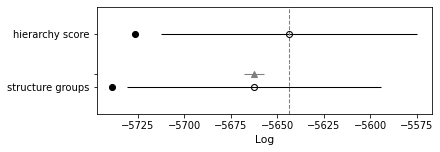

In [47]:
az.plot_compare(comparison, insample_dev=True, plot_ic_diff=True, plot_standard_error=True)

In [45]:
comparison['loo']

hierarchy score    -5643.698654
structure groups   -5662.512377
Name: loo, dtype: object

In [20]:
loo_hs = az.loo(idata_hs, pointwise=True)
loo_sg = az.loo(idata_sg, pointwise=True)

In [60]:
# matches
print(loo_hs['loo_i'].shape)
print(np.sum(loo_hs['loo_i']))
print(np.sum(loo_sg['loo_i']))
diff = loo_hs['loo_i'] - loo_sg['loo_i']
print(np.mean(diff))
print(np.sqrt(len(diff) * np.var(diff)))

(4409,)
<xarray.DataArray 'loo_i' ()>
array(-5643.69865423)
<xarray.DataArray 'loo_i' ()>
array(-5662.51237669)
<xarray.DataArray 'loo_i' ()>
array(18.81372246)
<xarray.DataArray 'loo_i' ()>
array(5.60154632)


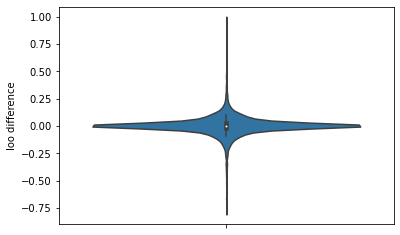

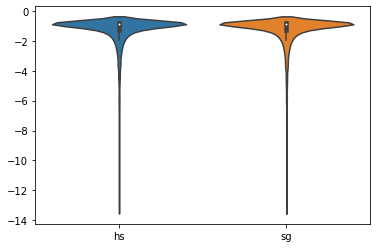

In [67]:
loo_i_df = pd.DataFrame({
    "hs" : loo_hs['loo_i'],
    "sg" : loo_sg['loo_i'],
})

fig, ax = plt.subplots()
sns.violinplot(y=diff, ax=ax)
ax.set_ylabel("loo difference")

fig, ax = plt.subplots()
sns.violinplot(data=loo_i_df, ax=ax)

In [75]:
plt.plot(loo_hs['loo_i'])
az.plot_elpd({"hierarchy score": idata_hs, "structure groups": idata_sg},)

70.46291524087744

In [2]:
from itertools import product
from tqdm.notebook import tqdm

models = ['structural_groups', 'hierarchy_score']
datasets = ["allen_fc", "allen_bo"]

combinations = list(product(datasets, defined_measures, defined_stimuli, models))
loos = dict()

for dset, meas, stim, model in tqdm(combinations):
    try:
        idata = az.from_netcdf(f"/scratch.local/pspitzner/information_timescales/paper_plots/data/prepped/{dset}_{meas}_{stim}_{model}.h5")
        _ = az.loo(idata, pointwise=True)
        loos[f"{dset}_{meas}_{stim}_{model}"] = az.loo(idata, pointwise=True)
    except:
        # allen_bo does not have a spontaneous stimulus
        pass

dict_keys(['structural_groups', 'hierarchy_score'])

['tau_C', 'tau_R', 'R_tot']


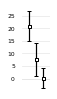

In [4]:

# FPS: The other panesl are quite big and we downscale them to ~60%.
# Here I used native / real-life units (100%), with font sizes ~8pt and 6pt.
fig, ax = plt.subplots(figsize=(4,3))

matplotlib.rcParams["savefig.facecolor"] = (0.0, 0.0, 0.0, 0.0)  # transparent figure bg
matplotlib.rcParams["axes.facecolor"] = (1.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["xtick.labelsize"]= 6
matplotlib.rcParams["ytick.labelsize"]= 6

dset = "allen_fc"
# dset = "allen_bo"
# stim = "spontaneous"
stim = "movie"
for mdx, meas in enumerate(defined_measures):
    if dset == "allen_bo" and stim == "spontaneous":
        raise ValueError("allen_bo does not have spontaneous stimulus")
    # this is the same what arviz.compare does
    # I decided to not use az.compare because it ranks the models, but we always want
    # to have "groups - hs".
    diff = (
        loos[f"{dset}_{meas}_{stim}_hierarchy_score"]["loo_i"]
        - loos[f"{dset}_{meas}_{stim}_structural_groups"]["loo_i"]
    )
    ax.errorbar(
        x=mdx + 1,
        y=np.sum(diff),
        yerr=np.sqrt(len(diff) * np.var(diff)),
        label=f"{meas}",
        fmt = "s",
        # markeredgewidth = 0.0,
        markersize = 3.0,
        markerfacecolor = 'white',
        ecolor = 'black',
        color = "black",
        elinewidth = 1.2,
        capsize = 2,
        clip_on=False,
    )

ax.set_xticks([])
# ax.set_ylim(-28, 5)
# yticks = [-25, -20, -15, -10, -5, 0]
yticks = [25, 20, 15, 10, 5, 0]
ax.set_yticks(yticks)
for y in yticks:
    ax.axhline(y, ls="-", lw=1.0 if y == 0 else 0.7, zorder=0, color="#E6E6E6")
ax.set_xlim(0, 4)
sns.despine(ax=ax, trim=False, bottom=True)
# ax.set_ylabel("ELPD difference")
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
print(defined_measures)

set_size(ax, w=1.0, h=3.0, b=0.1, l=0.7, t=0.1)
ax.get_figure().savefig(f"../img/model_comparison_{dset}_{stim}_all_measures.pdf")